<h1 style="text-align: center"> Dogs emotions classifier </h1>
<img src='./imgs/dataset-cover2.jpg' alt='Dog smile' />

## This notebook 
- Is designed for training and evaluating dog emotions using an interactive and visual approach. 
- It can also be applied in a UI format by running the ui.py script.

## Data preparing

In [1]:
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import random
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

___Dataset source___ - https://www.kaggle.com/datasets/danielshanbalico/dog-emotion


In [2]:
root_path = os.path.join(os.environ['HOME'],'./Documents/datasets/dog_emotion/')
images_path = os.path.join(root_path,'./images/')

In [3]:
df = pd.DataFrame(columns=['file', 'emotion'])

emotions = os.listdir(images_path)

for emotion in tqdm(emotions):
    images_names = pd.Series(os.listdir(images_path + emotion), name='file')
    images_names = emotion + '/' + images_names
    
    emotions_types = pd.Series(len(images_names) * [emotion], name='emotion')
    tmp_df = pd.concat([images_names, emotions_types], axis=1)
    
    df = pd.concat([df, tmp_df], ignore_index=True)
    
df

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 596.14it/s]


,file,emotion
0,relaxed/0ul4hqrEYeDM1NwY5XG7LvdWkabiRR271.jpg,relaxed
1,relaxed/yDEpkHnIbj9TfhlmQO8PZtMnDhbUCb657.jpg,relaxed
2,relaxed/KZIzTxRaNaN6zLktJyF23mQZ1m6Z91583.jpg,relaxed
3,relaxed/pFHMCosKL75EuxUtsNxAl2v8U4CyTz962.jpg,relaxed
4,relaxed/40f07vcS5nQY6ipaa433syG0AoOlZe670.jpg,relaxed
...,...,...
3995,happy/ADrmYzHX2AgmZ6xWL5MPAquix69Mbf191.jpg,happy
3996,happy/VxTjKcwiawzTmr0Yy9KkyegCpJn12D563.jpg,happy
3997,happy/NNCFE83MzorDpf39u8CqyjPNrUitU3403.jpg,happy
3998,happy/6jxX8mYvWGiDjHIE9sdj1zPTkiXRXU685.jpg,happy


In [4]:
## If label file already has been generated, then skip
labels_file =  os.path.join(root_path,'./images_labels.csv')
if not os.path.isfile(labels_file):
    df.to_csv(labels_file)

In [5]:
import torch

## one-hot label
# 'happy' ==> [0, 1, 0, 0]
def label_to_class(label):
    labels = ['angry', 'happy', 'relaxed', 'sad']
    return torch.Tensor([float(label == l) for l in labels], )

# [0, 1, 0, 0] ==> 'happy'
def class_to_label(c):
    labels = ['angry', 'happy', 'relaxed', 'sad']
    idx = c.tolist().index(1)
    if idx >= len(labels):
        print('NO LABEL TO THIS CLASS')
        return None
    return labels[idx]

In [6]:
import os
import pandas as pd
from torchvision.io import read_image
import torchvision.transforms as transforms

tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ConvertImageDtype(torch.float32),
])


data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])
class Dataset(Dataset):
    def __init__(self, images_path, labels_csv_file_path, transform=None, augment= None):
        self.images_path = images_path
        self.transform = transform
        self.labels = pd.read_csv(labels_csv_file_path)
        self.augment = augment
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
#         image= np.random.rand(3, 224, 224)
        image =  torch.randn(3, 224, 224) 
        label = torch.tensor([0., 0., 0., 0.]) 
        try:
            image = read_image(self.images_path + self.labels.iloc[idx, 1])
            label = label_to_class(self.labels.iloc[idx, 2])
            if self.transform:
                image = self.transform(image)
            if self.augment:
                if random.random() >0.33: 
                    image = self.augment(image)
        except Exception as e:
#             print(f"Error occurred at index {idx}: {e}")
            pass

        return image, label

In [7]:
## generate train, valid and test datasets
batch_size = 32

full_dataset = Dataset(images_path, labels_file, transform = tf, augment = data_augmentation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_data = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_data   = DataLoader(val_dataset,   batch_size= batch_size, shuffle=True)

/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


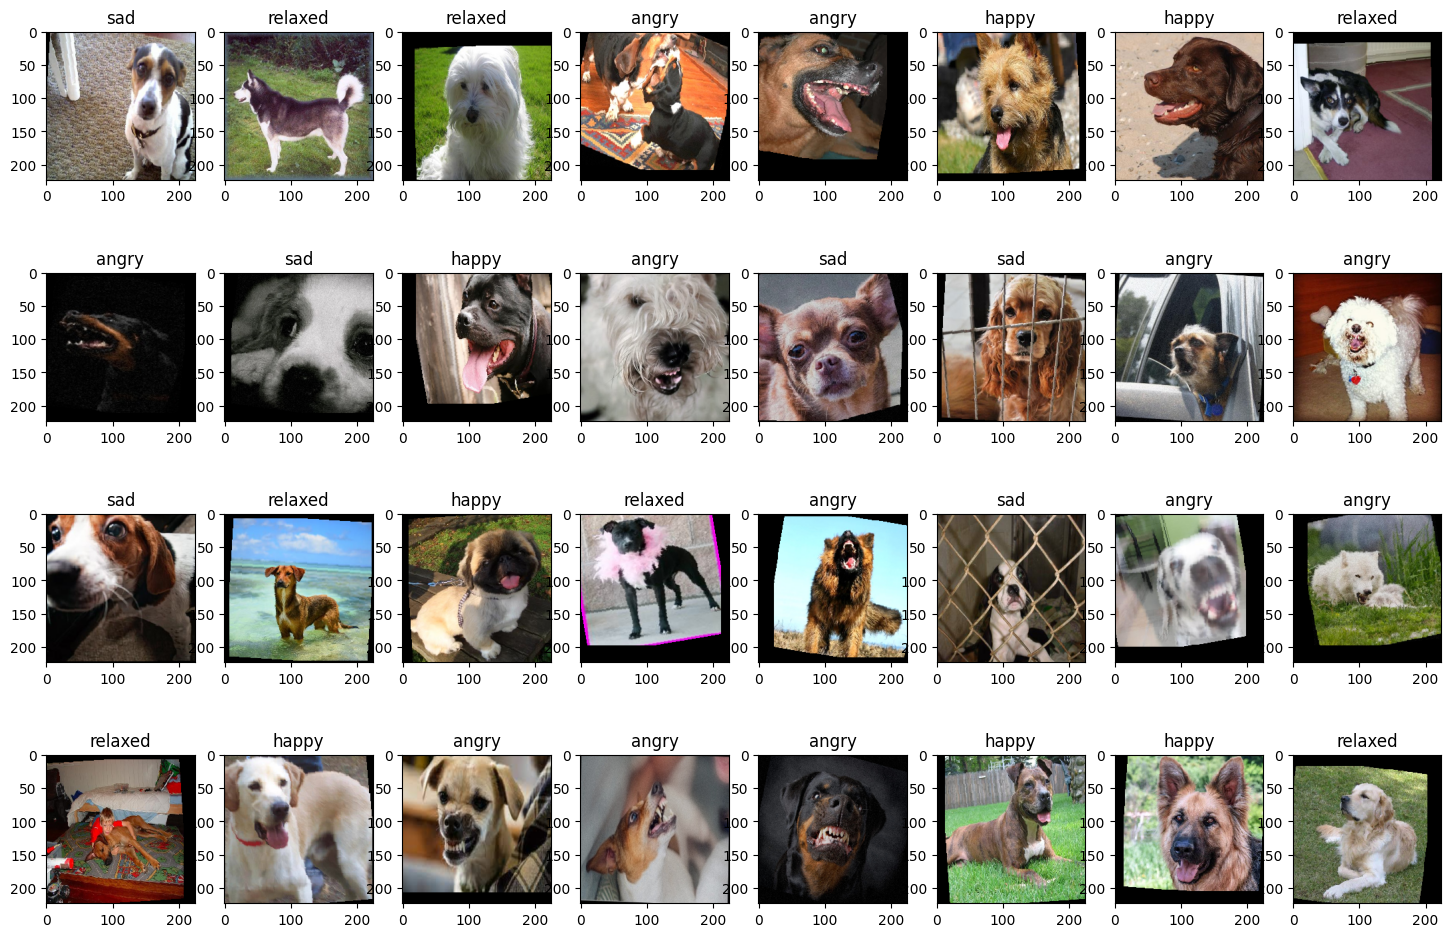

In [8]:
train_images, train_labels = next(iter(train_data))

rows, cols = batch_size//8, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, batch_size//8*3))  ## adaptive batch size

for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[r, c].title.set_text(class_to_label(train_labels[i]))

## Model building

In [9]:
from torchvision import models
# from torchvision.models import ResNet50_Weights, AlexNet_Weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'resnet'
num_class = 4
assert model_name in ['alexnet', 'resnet', 'ViT', 'CNN'], f'Model to be selected as alexnet, resnet, or ViT.'

if model_name == 'alexnet':
    model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) 
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, num_class)  
elif model_name == 'resnet':
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_class)  
elif model_name =='ViT':
    # optional 1: use torch's buildin model 
    model = models.vit_b_16(weights = models.vision_transformer.ViT_B_16_Weights.IMAGENET1K_V1)
    num_features = model.heads.head.in_features
    model.heads.head = nn.Linear(num_features, num_class)
    
#     ### optional 2: use scatched ViT code , same structure as what of option1 
#     import sys
#     sys.path.append('./models')
#     from my_ViT import ViT
#     model = ViT(
#         img_size=224,
#         patch_size=16,
#         embed_dim=768,
#         hidden_dim=3072,
#         num_heads=12,
#         num_layers=12,
#         num_classes=4 )
    
else: ## CNN
    import sys
    sys.path.append('./models')
    from cnn import CNN
    model = CNN()

model = model.to(device)
print(f'Model: {model_name}, Device: {device}.')


Model: resnet, Device: cuda.


## Model training

In [10]:
def train(model, optim, criterion, train_data, val_data, epochs=20):
    losses = {
        'train': [],
        'val':   []
    }
    
    for epoch in tqdm(range(epochs)):
        # train
        model.train()
        train_loss = 0
        for X_batch, Y_batch in train_data:
            optim.zero_grad()
            X_batch_cuda = X_batch.to(device)
            Y_batch_cuda = Y_batch.to(device)
            X_pred_cuda = model(X_batch_cuda)
            loss = criterion(X_pred_cuda, Y_batch_cuda)
            loss.backward()   ## 计算梯度
            optim.step()      ## 使用前一步计算的梯度， 更行网络参数
            scheduler.step()  ## 调整学习率
            train_loss += loss
        train_loss = train_loss.item() / len(train_data)
        losses['train'].append(train_loss)
              
        # val
        model.eval()
        X_valbatch, Y_valbatch = next(iter(val_data))  ## 每次就运行一次
        with torch.no_grad():
            X_valpred = model(X_valbatch.to(device))
        val_loss = criterion(X_valpred, Y_valbatch.to(device))
        losses['val'].append(val_loss.item())
        
        print(f'Epoch: {epoch + 1}/{epochs}; train_loss: {train_loss}; val_loss: {val_loss}')

    return losses

In [11]:
# ## load model, only for loading trained model  
# folder_name =  os.path.join(root_path,'./checkpoints')
# check_point_path = os.path.join(folder_name,'./'+model_name_+'_100epochs.pth')
# check_point = torch.load(check_point_path)
# model_state = check_point['model_state_dict']
# model.load_state_dict(model_state)

In [12]:
import torch.optim.lr_scheduler as lr_scheduler
import math
epochs =  20


lr =0.001
lrf = 0.01


criterion = torch.nn.CrossEntropyLoss() 
pg = [p for p in model.parameters() if p.requires_grad]

# Scheduler https://arxiv.org/pdf/1812.01187.pdf
optim = torch.optim.SGD(pg, lr=lr, momentum=0.9, weight_decay=5E-5)  
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf  
scheduler = lr_scheduler.LambdaLR(optim, lr_lambda=lf)

## start to train
start = time.time()

losses = train(model, optim, criterion, train_data, val_data, epochs=epochs)
end = time.time()
print('Train time per epoch:', (end- start)/epochs, 'seconds.')

  5%|██▏                                         | 1/20 [00:17<05:33, 17.53s/it]

Epoch: 1/20; train_loss: 1.3237301635742187; val_loss: 1.25011146068573


 10%|████▍                                       | 2/20 [00:34<05:10, 17.24s/it]

Epoch: 2/20; train_loss: 1.1598382568359376; val_loss: 1.0511128902435303


 15%|██████▌                                     | 3/20 [00:51<04:50, 17.08s/it]

Epoch: 3/20; train_loss: 1.026961212158203; val_loss: 0.926853358745575


 20%|████████▊                                   | 4/20 [01:08<04:30, 16.89s/it]

Epoch: 4/20; train_loss: 0.9119041442871094; val_loss: 0.7925060987472534


 25%|███████████                                 | 5/20 [01:24<04:13, 16.90s/it]

Epoch: 5/20; train_loss: 0.8032982635498047; val_loss: 0.7487547397613525


 30%|█████████████▏                              | 6/20 [01:41<03:55, 16.79s/it]

Epoch: 6/20; train_loss: 0.6994326782226562; val_loss: 0.7380284667015076


 35%|███████████████▍                            | 7/20 [01:57<03:36, 16.68s/it]

Epoch: 7/20; train_loss: 0.6053083419799805; val_loss: 0.5832464694976807


 40%|█████████████████▌                          | 8/20 [02:14<03:20, 16.69s/it]

Epoch: 8/20; train_loss: 0.5332857894897461; val_loss: 0.5728097558021545


 45%|███████████████████▊                        | 9/20 [02:31<03:03, 16.67s/it]

Epoch: 9/20; train_loss: 0.47674217224121096; val_loss: 0.6499303579330444


 50%|█████████████████████▌                     | 10/20 [02:48<02:46, 16.68s/it]

Epoch: 10/20; train_loss: 0.4294388961791992; val_loss: 0.31682658195495605


 55%|███████████████████████▋                   | 11/20 [03:04<02:30, 16.69s/it]

Epoch: 11/20; train_loss: 0.37654106140136717; val_loss: 0.3280259072780609


 60%|█████████████████████████▊                 | 12/20 [03:21<02:14, 16.77s/it]

Epoch: 12/20; train_loss: 0.35280670166015626; val_loss: 0.32724621891975403


 65%|███████████████████████████▉               | 13/20 [03:38<01:58, 16.87s/it]

Epoch: 13/20; train_loss: 0.33507160186767576; val_loss: 0.36619463562965393


 70%|██████████████████████████████             | 14/20 [03:55<01:40, 16.79s/it]

Epoch: 14/20; train_loss: 0.29341180801391603; val_loss: 0.2557559013366699


 75%|████████████████████████████████▎          | 15/20 [04:12<01:23, 16.76s/it]

Epoch: 15/20; train_loss: 0.2684237670898437; val_loss: 0.40507543087005615


 80%|██████████████████████████████████▍        | 16/20 [04:28<01:07, 16.77s/it]

Epoch: 16/20; train_loss: 0.24710857391357421; val_loss: 0.38731423020362854


 85%|████████████████████████████████████▌      | 17/20 [04:45<00:50, 16.75s/it]

Epoch: 17/20; train_loss: 0.22206642150878905; val_loss: 0.24135960638523102


 90%|██████████████████████████████████████▋    | 18/20 [05:02<00:33, 16.71s/it]

Epoch: 18/20; train_loss: 0.21052228927612304; val_loss: 0.49446091055870056


 95%|████████████████████████████████████████▊  | 19/20 [05:19<00:16, 16.82s/it]

Epoch: 19/20; train_loss: 0.19487417221069336; val_loss: 0.2934148907661438


100%|███████████████████████████████████████████| 20/20 [05:36<00:00, 16.81s/it]

Epoch: 20/20; train_loss: 0.17426063537597655; val_loss: 0.25148066878318787
Train time per epoch: 16.81393035650253 seconds.


In [13]:
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'learning_rate': lr,
    'batch_size': batch_size,
    'loss function': criterion
}

In [14]:
# ## save model in case need
folder_name =  os.path.join(root_path,'./checkpoints')
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
ensure_directory_exists(folder_name)
pth_name =  os.path.join(folder_name, model_name+'_'+str(epochs)+'epochs.pth')
# check_point = torch.save(checkpoint, pth_name)
torch.save(checkpoint, pth_name)  

## Evaluation

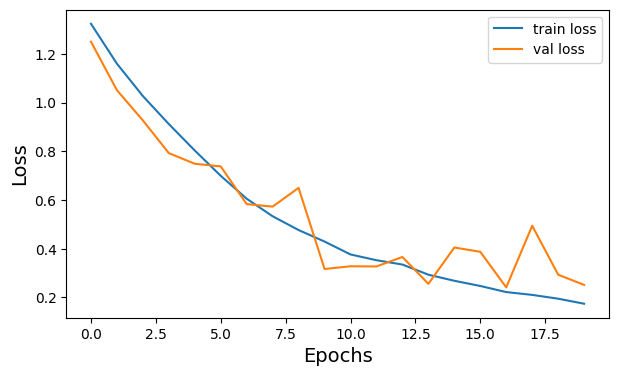

In [15]:
plt.figure(figsize = (7,4))
plt.plot(losses['train'], label='train loss')
plt.plot(losses['val'],   label='val loss')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.legend()
plt.savefig(os.path.join(folder_name, model_name+'_'+'loss.pdf'))

/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


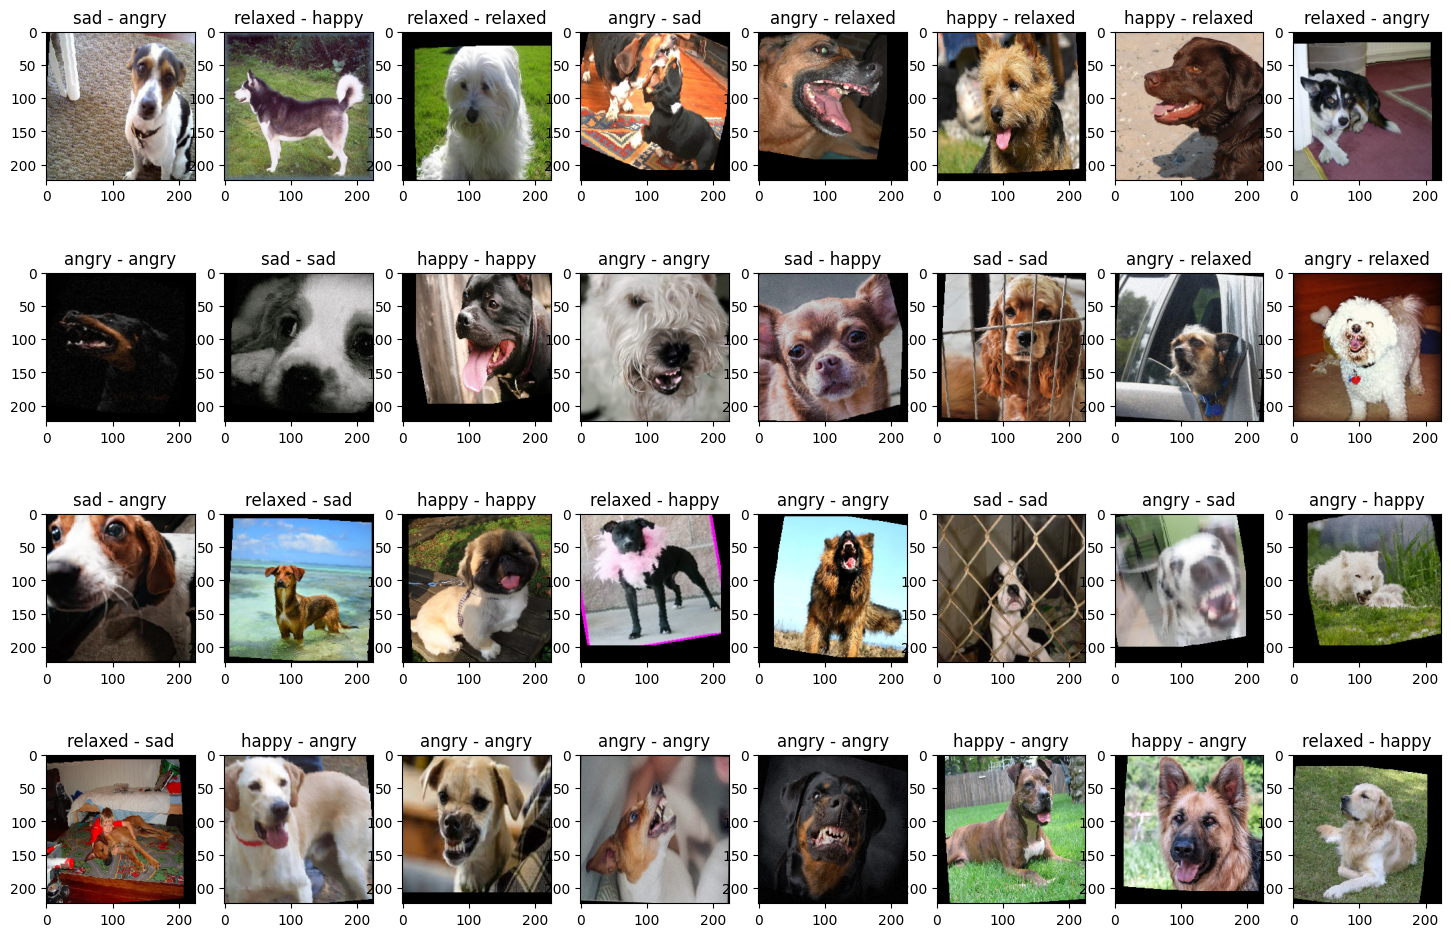

In [16]:
val_images, val_labels = next(iter(val_data))
emotions = os.listdir(images_path)
val_preds = model(val_images.to(device))

rows, cols = batch_size//8, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, batch_size//8*3))

for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[r, c].title.set_text(f'{class_to_label(train_labels[i])} - {emotions[torch.argmax(val_preds[i]).item()]}')

/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy:0.87625 
Precision: 0.8782193516079928
Recall: 0.876753111309761
F1 score: 0.8767712823078874


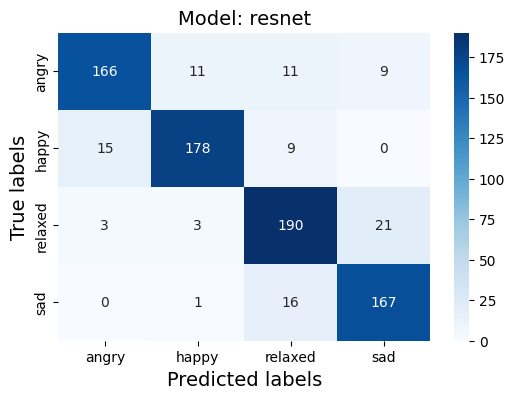

In [17]:
## Evaluate, accuracy, precision, recall, f1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Define class names
class_names = ['angry', 'happy', 'relaxed', 'sad']

def evaluate(model, val_data):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, targets in val_data:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1) ## 输出的size is (batch size, 4)
            _, targets = torch.max(targets, 1)  ## convert label of one-hot to scalar in 0,1,2,3
            all_targets.extend(targets.cpu().numpy())  ## 把GPU中的TENSOR 复制到CPU中， 再转成numpy 的ndarray
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    return accuracy, precision, recall, f1, all_targets, all_predictions

accuracy, precision, recall, f1, all_targets, all_predictions = evaluate(model, val_data)
result =f'Accuracy:{accuracy} \nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}'
print(result)

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels',fontsize = 14)
plt.ylabel('True labels',fontsize = 14)
plt.title('Model: '+model_name, fontsize = 14)
plt.savefig(os.path.join(folder_name, model_name+'_'+'confusionMatrix_'+result+'.pdf'))
plt.show()